## **СТОЛБЦЫ ДАТАСЕТА:**

**Id**

**name**

**est_diameter_min** – минимальный диаметр косм. объекта (астероид, комета) рядом с Землёй (км)

**est_diameter_max** – максимальный диаметр косм. объекта

**relative_velocity** – скорость относительно Земли (км/с)

**miss_distance** – расстояние, на кот. проходит рядом с Землёй (км)

**orbiting_body** – тело, вокруг которого вращается (везде Земля)

**sentry_object** – ведётся ли за ним авто мониторинг (везде  false)

**absolute_magnitude** – звёздная величина (яркость)

**hazardous** – опасный для Земли / нет

In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("..//static//csv//neo.csv")
print(df.columns)

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')


Бизнес-цели:

1) Увеличение безопасности Земли

2) Увеличение информации о безопасных космических объектах, на поверхности которых можно проводить исследования 


Цели технического проекта:

1) Построить модель машинного обучения, которая сможет предсказать, нужно ли вести наблюдения за космическим объектом, как за опасным для Земли. Вход: est_diameter_min, est_diameter_max, relative_velocity, miss_distance, absolute_magnitude, hazardous. Целевой признак: hazardous

2) Построить модель машинного обучения, которая сможет предсказать, безопасный ли объект для проведения исследований на его поверхности. Вход: est_diameter_min, est_diameter_max, relative_velocity, miss_distance, absolute_magnitude, hazardous. Целевой признак: hazardous

**ПОДГОТОВКА ДАННЫХ**

Т.к. hazardous является целевым признаком, то необходимо, чтобы данных об опасных и безопасных объектах было примерно равное количество. Безопасных объектов гораздо больше, поэтому можно произвести undersampling для того, чтобы количество безопасных и опасных объектов стало равным 

In [255]:

print('НАЧАЛЬНОЕ РАСПРЕДЕЛЕНИЕ')
true_hazardous = df[df['hazardous'] == True].shape[0]
print(f'Кол-во объектов с hazardous = true: {true_hazardous}')

false_hazardous = df[df['hazardous'] == False].shape[0]
print(f'Кол-во объектов с hazardous = false: {false_hazardous}')


true_count = df[df['hazardous'] == True].shape[0]


false_count = df[df['hazardous'] == False].shape[0]


# разделение датасета на 2 части по hazardous
from sklearn.utils import resample
df_hazardous_true = df[df['hazardous'] == True]
df_hazardous_false = df[df['hazardous'] == False]

# undersampling к части с Hazardous=false
df_hazardous_false_undersampled = resample(df_hazardous_false, 
                                           replace=False,  
                                           n_samples=len(df_hazardous_true),     #столько записей, сколько в df_hazardous_true
                                           random_state=123) 

# Объединение 2 частей
df_balanced = pd.concat([df_hazardous_true, df_hazardous_false_undersampled])

# Перемешивание записей
df = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)


print('\nСБАЛАНСИРОВАННОЕ РАСПРЕДЕЛЕНИЕ')
true_hazardous = df[df['hazardous'] == True].shape[0]
print(f'Кол-во объектов с hazardous = true: {true_hazardous}')

false_hazardous = df[df['hazardous'] == False].shape[0]
print(f'Кол-во объектов с hazardous = false: {false_hazardous}')


НАЧАЛЬНОЕ РАСПРЕДЕЛЕНИЕ
Кол-во объектов с hazardous = true: 8840
Кол-во объектов с hazardous = false: 81996

СБАЛАНСИРОВАННОЕ РАСПРЕДЕЛЕНИЕ
Кол-во объектов с hazardous = true: 8840
Кол-во объектов с hazardous = false: 8840



Проверка на выбросы. В столбцах est_diameter_min, est_diameter_max, relative_velocity есть единичные выбросы, которые значительно больше основного распределения (est_diameter_min - которые больше примерно 3;  est_diameter_max - которые больше примерно 5;  relative_velocity - которые больше примерно 175000), и в столбце absolute_magnitude есть выбросы, которые значительно ниже основного распределния (примерно меньше 13). Эти единичные выбросы можно удалить. Остальные же значения, находящиеся за рамками основного распределения стоит оставить, т.к. они представляют из себя полезный шум

После удаления единичных выбросов видно, что количество записей уменьшилось очень незначительно

Количество записей до устранения выбросов: 17680


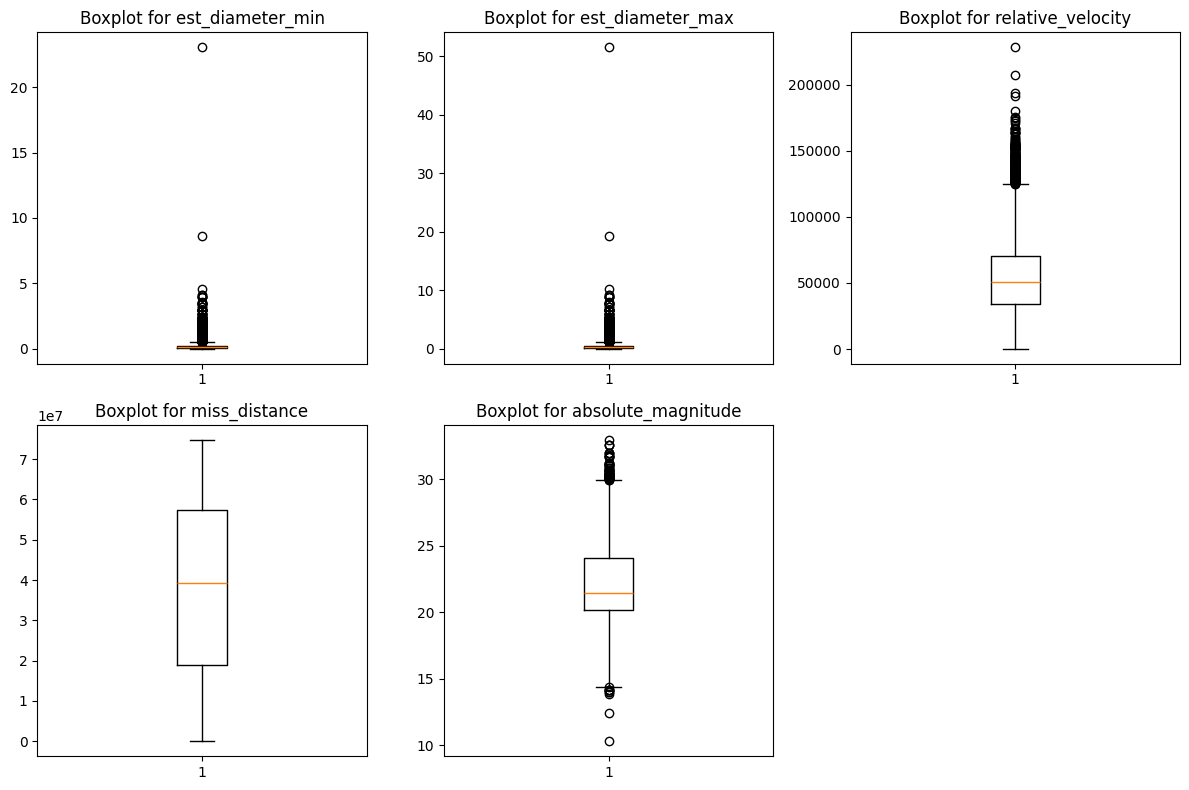

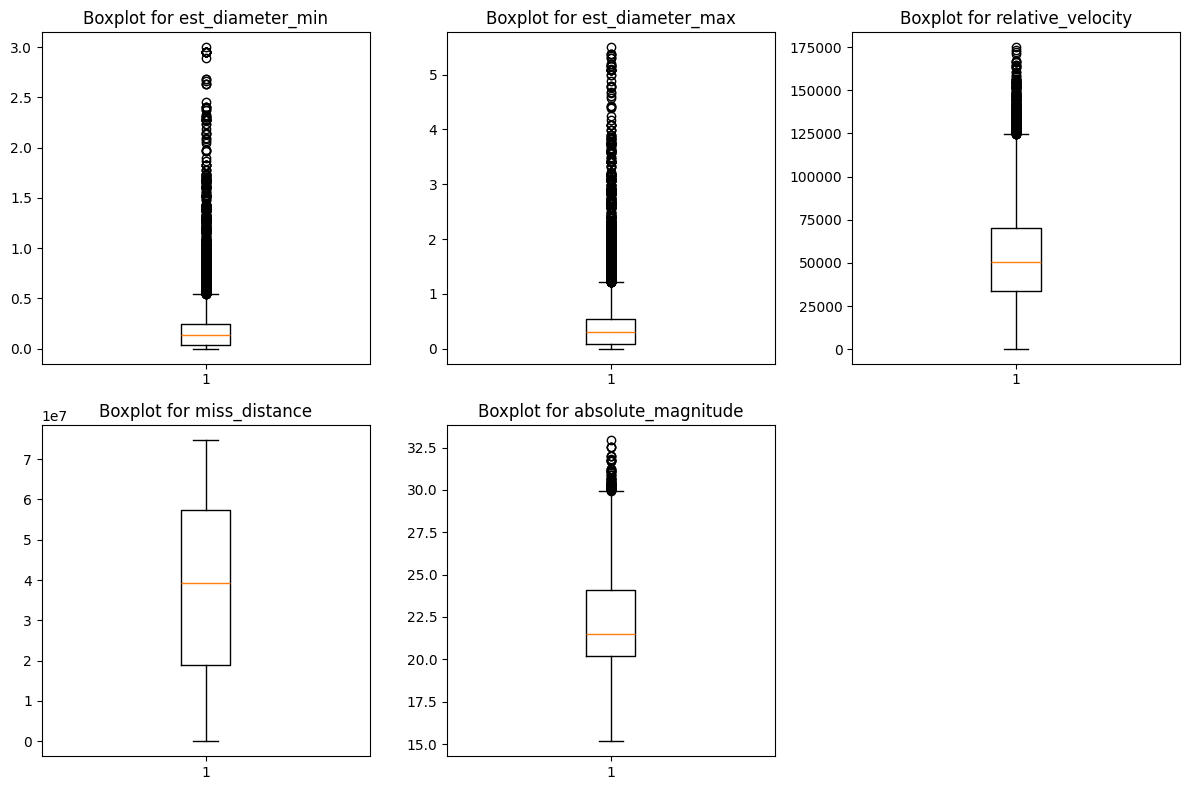

Количество записей после устранения выбросов: 17638


In [256]:
numeric_cols = df.select_dtypes(include=['number']).columns

#все столбцы, кроме id
numeric_cols = [col for col in numeric_cols if col != 'id']


print(f'Количество записей до устранения выбросов: {len(df)}')

plt.figure(figsize=(12, 8))
   

for i, col in enumerate(numeric_cols, 1):
    if col == 'id':
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i) 
    plt.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()


#Удаление единичных выбросов
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    if col == 'id':
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if (col=='est_diameter_min'):
        df = df[~((df[col] > 3))]
    if (col=='est_diameter_max'):
        df = df[~((df[col] > 5.5))]
    if (col=='relative_velocity'):
        df = df[~((df[col] > 175000))]
    if (col=='absolute_magnitude'):
        df = df[~((df[col] < 13))]
    
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i)
    plt.boxplot(x=df[col].dropna()) 
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

print(f'Количество записей после устранения выбросов: {len(df)}')

Пропущенных значений нет, значит решать данную проблему не надо

In [257]:
#проверка на пропущенные значения
columns_with_nulls = []
for col in df.columns:
  if df[col].isnull().sum() > 0:  
    columns_with_nulls.append(col)
print(f"Столбцы с null: {columns_with_nulls}")

Столбцы с null: []


**РАЗБИЕНИЕ НА ВЫБОРКИ**

После разбиения в обучающую выборку попало практически равное количество безопасных и опасных объектов, поэтому применять методы аугментации данных нет необходимости

Размер обучающей выборки: 14110
Размер контрольной выборки: 1764
Размер тестовой выборки: 1764


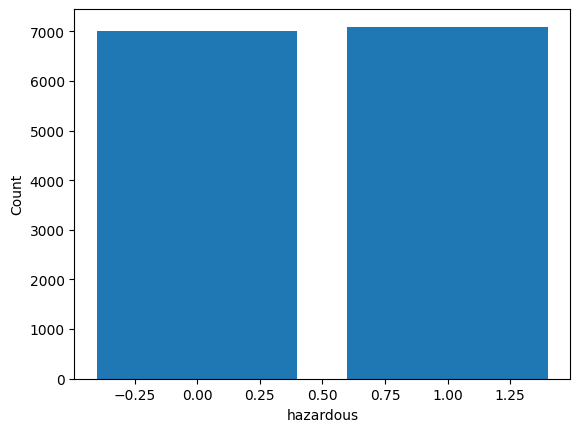

hazardous
True     7094
False    7016
Name: count, dtype: int64


In [258]:
from sklearn.model_selection import train_test_split
data=df[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude', 'hazardous']].copy()


# сначала разделение записей на 80% и 20%, где 80% - обучающая выборка
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# потом разделение остальных 20% поровну на контрольную и тестовую выборки
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Проверка размеров выборок
print("Размер обучающей выборки:", len(train_data))
print("Размер контрольной выборки:", len(val_data))
print("Размер тестовой выборки:", len(test_data))


# построение столбчатой диаграммы по столбцу rating_stars (сбалансированность обучающей выборки)
hazardous_counts = train_data['hazardous'].value_counts()

plt.bar(hazardous_counts.index, hazardous_counts.values)
plt.xlabel('hazardous')
plt.ylabel('Count')
plt.show()

print(train_data["hazardous"].value_counts())

## Конструирование признаков

**Унитарное кодирование категориальных признаков (для всех категориальных признаков в датасете)**

т.к. в столбцах orbiting_body и sentry_object есть только 1 различное категориальное значение, то при использовании encoder = OneHotEncoder(sparse_output=False, drop="first") срабатывает условие drop="first", который удаляет первое категориальное значение для предотвращения линейной зависимости между столбцами. Поэтому в случае с hazardous использован OneHotEncoder с параметром drop="first", а для orbiting_body и sentry_object без него.

Для решения обеих задач (бизнес-целей и технических целей) нужен только признак hazardous_True

In [259]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder(sparse_output=False, drop="first")
encoder1 = OneHotEncoder(sparse_output=False)

encoded_values = encoder.fit_transform(df[["hazardous"]])
encoded_columns = encoder.get_feature_names_out(["hazardous"])

encoded_values1 = encoder1.fit_transform(df[["orbiting_body", "sentry_object"]])
encoded_columns1 = encoder1.get_feature_names_out(["orbiting_body", "sentry_object"])


encoded_values_df1 = pd.DataFrame(encoded_values1, columns=encoded_columns1)
encoded_values_df2 = pd.DataFrame(encoded_values, columns=encoded_columns)


encoded_values_df = pd.concat([encoded_values_df1, encoded_values_df2], axis=1)
print(encoded_values_df)


       orbiting_body_Earth  sentry_object_False  hazardous_True
0                      1.0                  1.0             1.0
1                      1.0                  1.0             1.0
2                      1.0                  1.0             0.0
3                      1.0                  1.0             1.0
4                      1.0                  1.0             0.0
...                    ...                  ...             ...
17633                  1.0                  1.0             1.0
17634                  1.0                  1.0             0.0
17635                  1.0                  1.0             1.0
17636                  1.0                  1.0             0.0
17637                  1.0                  1.0             0.0

[17638 rows x 3 columns]


Унитарное кодирование для самой обучающей выборки

In [260]:
#обучающая выборка
train_data_encoded = pd.get_dummies(train_data, columns=['hazardous'], drop_first=True, dtype=float)
train_data = train_data_encoded

#валидационная
val_data_encoded = pd.get_dummies(val_data, columns=['hazardous'], drop_first=True, dtype=float)
val_data = val_data_encoded

#тестовая
test_data_encoded = pd.get_dummies(test_data, columns=['hazardous'], drop_first=True, dtype=float)
test_data = test_data_encoded

print(train_data)

       est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
1882           0.056566          0.126485       53181.770308   1.608163e+07   
10162          0.108282          0.242125       71641.177993   6.633209e+07   
13664          0.186447          0.416908       72150.829803   7.266875e+07   
17556          0.003052          0.006824       13472.804594   2.411481e+07   
13523          0.048368          0.108153       31281.647283   2.217165e+06   
...                 ...               ...                ...            ...   
11308          0.069913          0.156329       38271.512861   5.439281e+07   
11990          0.152249          0.340440       58488.870909   7.232920e+07   
5402           0.008801          0.019681       20926.865447   2.458771e+07   
861            0.183889          0.411188       40232.968565   3.188090e+07   
15832          0.183889          0.411188       89521.116646   5.187941e+07   

       absolute_magnitude  hazardous_True  
1882   

**Дискретизация числовых признаков**

дискретизируется скорость relative_velocity


In [261]:
velocity_labels=['Небольшая скорость', 'Средняя скорость', 'Большая скорость']

#обучающая выборка
train_data_discretized = train_data
#равномерная группировка (для каждой категории диапазон чисел одинаковой длины)
train_data_discretized['relative_velocity'] = pd.cut(train_data['relative_velocity'], bins=3, labels=velocity_labels)
train_data = train_data_discretized

#валидационная выборка
val_data_discretized = val_data
val_data_discretized['relative_velocity'] = pd.cut(val_data['relative_velocity'], bins=3, labels=velocity_labels)
val_data = val_data_discretized

#тестовая выборка
test_data_discretized = test_data
test_data_discretized['relative_velocity'] = pd.cut(test_data['relative_velocity'], bins=3, labels=velocity_labels)
test_data = test_data_discretized

print(train_data_discretized)
print(train_data["relative_velocity"].value_counts())

       est_diameter_min  est_diameter_max   relative_velocity  miss_distance  \
1882           0.056566          0.126485  Небольшая скорость   1.608163e+07   
10162          0.108282          0.242125    Средняя скорость   6.633209e+07   
13664          0.186447          0.416908    Средняя скорость   7.266875e+07   
17556          0.003052          0.006824  Небольшая скорость   2.411481e+07   
13523          0.048368          0.108153  Небольшая скорость   2.217165e+06   
...                 ...               ...                 ...            ...   
11308          0.069913          0.156329  Небольшая скорость   5.439281e+07   
11990          0.152249          0.340440  Небольшая скорость   7.232920e+07   
5402           0.008801          0.019681  Небольшая скорость   2.458771e+07   
861            0.183889          0.411188  Небольшая скорость   3.188090e+07   
15832          0.183889          0.411188    Средняя скорость   5.187941e+07   

       absolute_magnitude  hazardous_Tr

**Ручной синтез признаков**

На основании максимального и минимального радиуса объекта можно найти среднее значение диаметра

In [262]:
train_data['average_diameter'] = (train_data['est_diameter_min'] + train_data['est_diameter_max']) / 2
val_data['average_diameter'] = (val_data['est_diameter_min'] + val_data['est_diameter_max']) / 2
test_data['average_diameter'] = (test_data['est_diameter_min'] + test_data['est_diameter_max']) / 2

**Масштабирование признаков**

In [263]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_cols = train_data.select_dtypes(include=['number']).columns

numeric_cols = numeric_cols.drop('hazardous_True')

train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
val_data[numeric_cols] = scaler.fit_transform(val_data[numeric_cols])
test_data[numeric_cols] = scaler.fit_transform(test_data[numeric_cols])

**Featuretools**

Featuretools не смог выявить дополнительных признаков по признакам, которые необходимы для решения поставленных задач

In [264]:
import featuretools as ft

es = ft.EntitySet(id='space_objects_data')
es = es.add_dataframe(dataframe_name='space_objects', dataframe=train_data, index='id')

# Генерация признаков
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="space_objects",
    agg_primitives=["mean", "count", "mode", "any"],
    max_depth=2,
)

# Преобразование признаков для контрольной и тестовой выборок
val_feature_matrix = ft.calculate_feature_matrix(features=feature_defs, entityset=es, instance_ids=val_data_encoded.index)
test_feature_matrix = ft.calculate_feature_matrix(features=feature_defs, entityset=es, instance_ids=test_data_encoded.index)

print(feature_matrix.head())

    est_diameter_min  est_diameter_max   relative_velocity  miss_distance  \
id                                                                          
0          -0.572328         -0.572328  Небольшая скорость      -1.014078   
1          -0.361244         -0.361244    Средняя скорость       1.278171   
2          -0.042204         -0.042204    Средняя скорость       1.567227   
3          -0.790752         -0.790752  Небольшая скорость      -0.647632   
4          -0.605790         -0.605790  Небольшая скорость      -1.646526   

    absolute_magnitude  hazardous_True  average_diameter  
id                                                        
0             0.447447             0.0         -0.572328  
1            -0.051566             0.0         -0.361244  
2            -0.469179             1.0         -0.042204  
3             2.691234             0.0         -0.790752  
4             0.567776             0.0         -0.605790  


c:\AI labs\aimenv\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index id not found in dataframe, creating new integer column
  warnings.warn(
c:\AI labs\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\AI labs\aimenv\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
c:\AI labs\aimenv\Lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['any', 'count', 'mean', 'mode']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for 

**Оценка качества наборов признаков**



У модели, построенной по логической регрессии, точность  (accuracy) составляет почти 85%, что является приемлемым значением. При этом, модель верно относит опасные объекты к опасным примерно в 80% случаев (precision), что может быть недостаточным значением 

Модель имеет показатель показатель полноты примерно 93%

Значение метрики f1 примерно 86%, что означает, что между точностью и полнотой модели хороший баланс

Среднее значение точности по кросс-валидации (Cross-Validation Mean) составляет около 85%, что близко к точности на тестовой выборке. Это указывает на то, что модель стабильна

Дисперсия (Cross-Validation Std) составляет меньше 1%, что говорит о том, что модель качественно выполняет предсказания на
тестовой выборке. Модель можно считать надёжной

У модели очень большая скорость вычислений и очень низкий показатель среднеквадратичной ошибки, что говорит о том, что модель обучилась хорошо

По диаграмме (матрице ошибок) можно увидеть, что модель большинство космических объектов оценила также, как есть на самом деле. Модель очень часто верно определяет опасные объекты, чуть хуже верно определяет неопасные объекты. Однако у неё есть склонность относить неопасные объекты к опасным

Accuracy: 0.8479801559177887
Precision: 0.8024464831804281
Полнота: 0.92524682651622
F1: 0.859482476252866
Cross-Validation Mean: 0.8499645641389085
Cross-Validation Std: 0.0053722448357894316
Время обучения модели: 0.01 секунд
Скорость вычисления: 0.00 секунд
Среднеквадратичная ошибка: 0.15


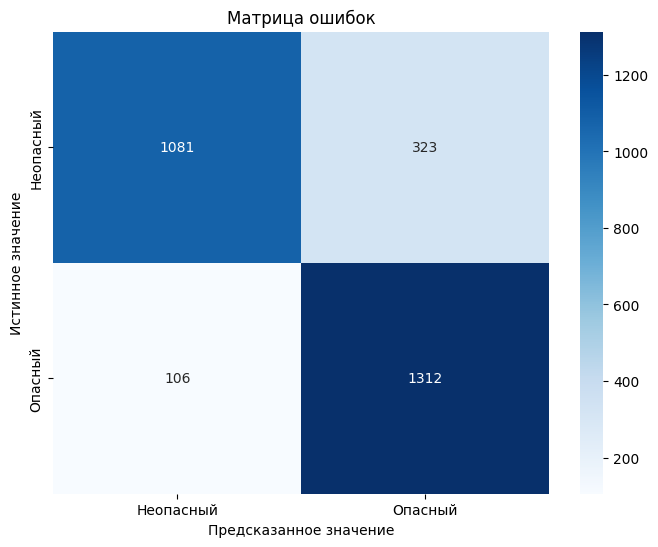

In [265]:
import time
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  r2_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import cross_val_score

# Разделение данных на обучающую и валидационную выборки. Удаляем целевую переменную
X = feature_matrix.drop('hazardous_True', axis=1)
y = feature_matrix['hazardous_True']

# One-hot encoding для категориальных переменных (преобразование категориальных объектов в числовые)
X = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = LogisticRegression()

# Начинаем отсчет времени
start_time = time.time()
model.fit(X_train, y_train)

# Время обучения модели
train_time = time.time() - start_time

# Предсказания и оценка модели
start_time = time.time()
predictions = model.predict(X_test)
pred_time = time.time() - start_time



# Предсказательная способность
accuracy = accuracy_score(y_test, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='binary')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Полнота: {recall}")
print(f"F1: {f1}")


# Надежность
cv_scores = cross_val_score(model, X, y, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"Cross-Validation Mean: {cv_mean}")
print(f"Cross-Validation Std: {cv_std}")


print(f'Время обучения модели: {train_time:.2f} секунд')
print(f'Скорость вычисления: {pred_time:.2f} секунд')


mse = mean_squared_error(y_test, predictions)
print(f'Среднеквадратичная ошибка: {mse:.2f}')

# Визуализация предсказаний
confusions = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusions, annot=True, fmt='d', cmap='Blues', xticklabels=['Неопасный', 'Опасный'], yticklabels=['Неопасный', 'Опасный'])
plt.xlabel('Предсказанное значение')
plt.ylabel('Истинное значение')
plt.title('Матрица ошибок')
plt.show()